<a href="https://colab.research.google.com/github/GUNAPILLCO/neural_profit/blob/main/2_obtencion_preparacion_exploracion_datos/2_5_correlacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.5. Correlación

## 0. Clonado de repositorio, importación de librerías y carga del dataset

### Clonado de repositorio e importación de librerías

In [2]:
#Clonamos el repo
#LINK DE REPOSITORIO: https://github.com/GUNAPILLCO/neural_profit

!git clone https://github.com/GUNAPILLCO/neural_profit.git

Cloning into 'neural_profit'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 205 (delta 76), reused 34 (delta 19), pack-reused 89 (from 1)
Receiving objects: 100% (205/205), 108.83 MiB | 21.55 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Updating files: 100% (42/42), done.


In [14]:
import sys

#Instalación de librería pandas_market_calendars
#!{sys.executable} -m pip install -q pandas_market_calendars
#print("Librería instalada: pandas_market_calendars")

!{sys.executable} -m pip install -q ta
print("Librería instalada: technical-analysis")

# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import requests
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
# Calendario de mercados
#import pandas_market_calendars as mcal
import ta
from ta.momentum import StochasticOscillator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange

from scipy.stats import spearmanr

Librería instalada: technical-analysis


### Carga del dataset mnq_intraday_data

In [4]:
def load_df():
    """
    Función para cargar un archivo Parquet desde el repositorio clonado
    """
    # Definir la URL del archivo Parquet en GitHub
    df_path = '/content/neural_profit/2_obtencion_preparacion_exploracion_datos/mnq_intraday_data.parquet'

    # Leer el archivo Parquet y cargarlo en un DataFrame
    df = pd.read_parquet(df_path)

    # Asegurar que el índice esté en formato datetime
    df.index = pd.to_datetime(df.index)

    # Crear una nueva columna 'date' con la fecha extraída del índice
    df['date'] = df.index.date

    # Reordenar columnas: 'date', 'time_str', y luego el resto
    cols = ['date'] + [col for col in df.columns if col not in ['date']]

    df = df[cols]

    return df

In [5]:
mnq_intraday = load_df()

## 1. Definición de Target

Recordemos que nuestro target es el retorno de la variables 'close' y lo evaluaremos en tres ventanas de tiempo: 5, 15 y 30 minutos.

In [6]:
def add_targets (df):
  df['target_return_30'] = df.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))
  return df

In [7]:
mnq_intraday = add_targets(mnq_intraday)

## 2. Agregar indicadores técnicos

In [15]:
def indicadores_tecnicos(df=mnq_intraday, target='target_return_30' ):
  indicadores_tecnicos_lista = ['rsi_14', 'rsi_7', 'macd', 'bb_percent_20_20', 'bb_percent_30_20', 'atr_norm']

  def aplicar_por_dia (grupo):
        grupo = grupo.copy()
        #RSI 14 y RSI 7
        grupo['rsi_14'] = ta.momentum.RSIIndicator(grupo[target], window=14).rsi()
        grupo['rsi_7'] = ta.momentum.RSIIndicator(grupo[target], window=7).rsi()

        #MACD
        grupo['macd'] = ta.trend.MACD(grupo[target]).macd_diff()

        #BB PERCENT
        grupo['bb_percent_20_20'] = BollingerBands(grupo[target], window=20, window_dev=2).bollinger_pband()
        grupo['bb_percent_30_20'] = BollingerBands(grupo[target], window=30, window_dev=2).bollinger_pband()

        #ATR Normalizado
        atr = AverageTrueRange(high=grupo['high'], low=grupo['low'], close=grupo[target], window=14)
        grupo['atr'] = atr.average_true_range()
        grupo['atr_norm'] = grupo['atr'] / grupo[target]
        #atr = AverageTrueRange(high=grupo['high'], low=grupo['low'], close=grupo[target], window=14)
        #grupo['atr_norm'] = atr.average_true_range() / grupo[target]

        return grupo

  df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)
  return df, indicadores_tecnicos_lista

In [16]:
mnq_intraday, indicadores_tecnicos_lista = indicadores_tecnicos()

## 3. Añadir alpha factors de hipotesis

In [39]:
alpha_factors_lista = []

### 3.1. Hipotesis 1

In [24]:
def add_reversion_momentum_factor(df: pd.DataFrame,
                          price_col: str = 'close',
                          date_col: str = 'date',
                          window: int = 30) -> pd.DataFrame:
    """
    Agrega una columna 'reversion_media_factor' que es el 'momentum_rev_z_30' al DataFrame, representando el alpha factor
    de reversión a la media basado en el z-score invertido de log-retornos a N minutos.

    Parámetros:
    - df: DataFrame de entrada con columnas de precios y fechas
    - price_col: nombre de la columna de precios (default='close')
    - date_col: nombre de la columna de fecha o jornada (default='date')
    - window: cantidad de minutos para calcular el momentum (default=30)

    Retorna:
    - DataFrame con la columna 'reversion_media_factor' añadida
    """
    df = df.copy()

    def calc_reversal(x):
        m = np.log(x) - np.log(x.shift(window))
        return -(m - m.mean()) / m.std()

    af_1 = 'reversal_momentum_factor'
    df[af_1] = df.groupby(date_col)[price_col].transform(calc_reversal)
    #df = df.dropna(subset=['momentum_rev_z_30'])

    return df, af_1

In [25]:
mnq_intraday, alpha_factor_1 = add_reversion_momentum_factor(mnq_intraday)

In [52]:
indicadores_tecnicos_lista.append(alpha_factor_1)

### 3.2. Hipotesis 2

In [22]:
def add_reversal_media_factor(df: pd.DataFrame, window: int = 30, price_col: str = 'close') -> pd.DataFrame:
    """
    Agrega al DataFrame un alpha factor basado en la hipótesis 2 (reversión a la media),
    llamado 'reversal_score_{window}', calculado como z-score normalizado por jornada.

    No guarda columnas intermedias.

    Parámetros:
    - df: DataFrame con columnas 'date' y una columna de precios (por defecto 'close')
    - window: Ventana para el cálculo del z-score (en minutos)
    - price_col: Nombre de la columna de precios

    Retorna:
    - El DataFrame original con una nueva columna 'reversal_score_{window}'
    """
    z_col = f'_tmp_z_{window}'
    reversal_col = f'reversal_media_factor'

    # Calcular z-score por jornada
    df[z_col] = df.groupby('date')[price_col].transform(
        lambda x: (x - x.rolling(window=window, min_periods=1).mean()) /
                  x.rolling(window=window, min_periods=1).std()
    )

    # Normalizar el z-score por jornada
    df[reversal_col] = df.groupby('date')[z_col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    # Eliminar columna temporal
    df.drop(columns=[z_col], inplace=True)

    return df, reversal_col

In [27]:
mnq_intraday, alpha_factor_2 = add_reversal_media_factor(mnq_intraday)

In [53]:
indicadores_tecnicos_lista.append(alpha_factor_2)

### 3.3. Hipotesis 3

In [29]:
def add_reversion_vol_momentum_factor(df: pd.DataFrame,
                                      price_col: str = 'close',
                                      volume_col: str = 'volume',
                                      date_col: str = 'date',
                                      window: int = 30) -> pd.DataFrame:
    """
    Agrega una columna 'reversion_vol_momentum_factor' al DataFrame,
    que representa un alpha factor de reversión basado en:
    - Momentum a N minutos
    - Relación volumen actual / volumen promedio N
    - Z-score del factor por jornada
    - Inversión de signo para capturar reversión

    Parámetros:
    - df: DataFrame de entrada con columnas de precios, volumen y fechas
    - price_col: nombre de la columna de precios (default='close')
    - volume_col: nombre de la columna de volumen (default='volume')
    - date_col: nombre de la columna de fecha o jornada (default='date')
    - window: ventana en minutos para calcular momentum y volumen promedio (default=30)

    Retorna:
    - DataFrame con la columna 'reversion_vol_momentum_factor' añadida
    """
    df = df.copy()

    # 1. Calcular el momentum
    df['momentum'] = df.groupby(date_col)[price_col].transform(
        lambda x: np.log(x) - np.log(x.shift(window))
    )

    # 2. Calcular volumen promedio intradía (rolling por jornada)
    df['vol_avg'] = df.groupby(date_col)[volume_col].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

    # 3. Relación volumen actual / volumen promedio
    df['vol_ratio'] = df[volume_col] / df['vol_avg']

    # 4. Alpha factor crudo: momentum × vol_ratio
    df['mom_vol'] = df['momentum'] * df['vol_ratio']

    # 5. Normalización diaria y reversión
    af_name = 'reversion_vol_momentum_factor'
    df[af_name] = df.groupby(date_col)['mom_vol'].transform(
        lambda x: -(x - x.mean()) / x.std()
    )

    # 6. Limpieza opcional de columnas intermedias
    df.drop(columns=['momentum', 'vol_avg', 'vol_ratio', 'mom_vol'], inplace=True)

    return df, af_name

In [30]:
mnq_intraday, alpha_factor_3 = add_reversion_vol_momentum_factor(mnq_intraday)

In [54]:
indicadores_tecnicos_lista.append(alpha_factor_3)

### 4. Hipotesis 4

In [36]:
def add_opening_exhaustion_factor30(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Calcular métricas de apertura por jornada
    opening_start = "08:00:00"
    opening_end = "09:30:00"

    def get_opening_metrics(x):
        high = x.between_time(opening_start, opening_end)['high'].max()
        low = x.between_time(opening_start, opening_end)['low'].min()
        opening_range = high - low
        midpoint = (high + low) / 2
        return pd.Series({'range': opening_range, 'midpoint': midpoint})

    opening_df = df.groupby('date').apply(get_opening_metrics)

    # Calcular factor raw (solo después de 09:30)
    df = df.join(opening_df.rename(columns={'range': 'opening_range', 'midpoint': 'opening_midpoint'}), on='date')
    df['after_opening'] = df.index >= df.index.normalize() + pd.Timedelta("09:30:00")

    df['factor_raw'] = (
        (df['close'] - df['opening_midpoint']) / df['opening_range']
    ).where(df['after_opening'])

    # Calcular factor30 (z-score del raw, por día)
    af_name = 'factor30'
    df[af_name] = df.groupby('date')['factor_raw'].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    # Limpiar columnas intermedias
    df = df.drop(columns=[
        'opening_range', 'opening_midpoint', 'after_opening', 'factor_raw'
    ])

    return df, af_name

In [37]:
mnq_intraday, alpha_factor_4 = add_opening_exhaustion_factor30(mnq_intraday)

In [55]:
indicadores_tecnicos_lista.append(alpha_factor_4)

indicadores_te

In [56]:
indicadores_tecnicos_lista

['rsi_14',
 'rsi_7',
 'macd',
 'bb_percent_20_20',
 'bb_percent_30_20',
 'atr_norm',
 'reversal_momentum_factor',
 'reversal_media_factor',
 'reversion_vol_momentum_factor',
 'factor30']

## CORRELACIÓN


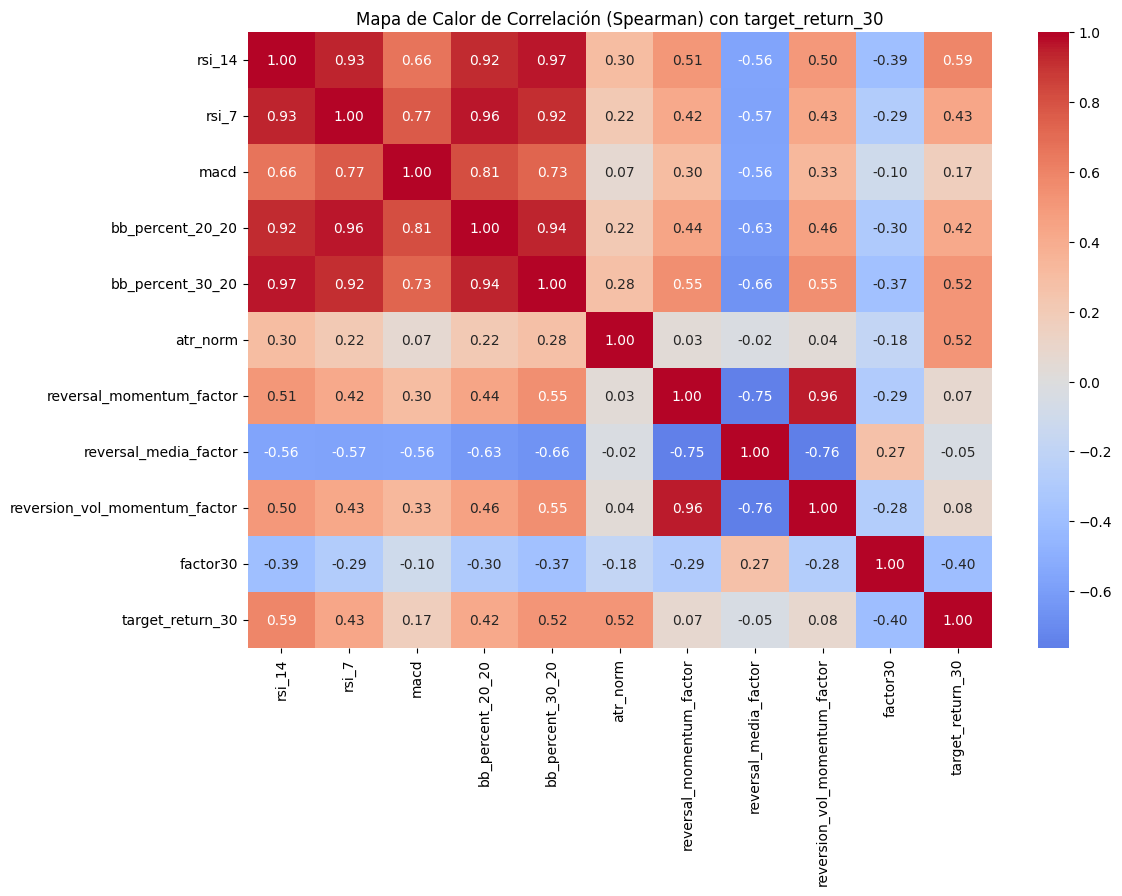

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de factores

# Calcular la correlación de Spearman con el target
correlaciones_target = mnq_intraday[indicadores_tecnicos_lista + ['target_return_30']].corr(method='spearman')['target_return_30']

# Eliminar la correlación del target consigo mismo
correlaciones_target = correlaciones_target.drop('target_return_30')

# Ordenar por el valor absoluto de la correlación
tabla_correlaciones = correlaciones_target.abs().sort_values(ascending=False)

# Crear tabla final con el signo original de la correlación
corr_target = correlaciones_target.loc[tabla_correlaciones.index].reset_index()
corr_target.columns = ['Factor', 'Correlación con target_return_30']

# ----- MAPA DE CALOR -----
# Subconjunto de variables + target para visualización
subset_corr = mnq_intraday[indicadores_tecnicos_lista + ['target_return_30']].corr(method='spearman')

plt.figure(figsize=(12, 8))
sns.heatmap(subset_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mapa de Calor de Correlación (Spearman) con target_return_30")
plt.show()

In [58]:
corr_target

,Factor,Correlación con target_return_30
0,rsi_14,0.588170
1,atr_norm,0.518952
2,bb_percent_30_20,0.516426
3,rsi_7,0.430543
4,bb_percent_20_20,0.415398
5,factor30,-0.402906
6,macd,0.166327
7,reversion_vol_momentum_factor,0.081307
8,reversal_momentum_factor,0.072542
9,reversal_media_factor,-0.047148


Para esto, el mapa de calor de correlación es una herramienta excelente, ya que te permite:

- Detectar redundancias: Si dos factores están altamente correlacionados (por ejemplo, > 0.9 o < -0.9), puede que estén aportando información similar.

- Identificar relaciones: Puedes descubrir patrones de comportamiento entre factores técnicos y alpha factors.

- Reducir dimensionalidad: Si hay grupos de factores similares, podrías considerar usar solo uno de cada grupo o aplicar PCA.

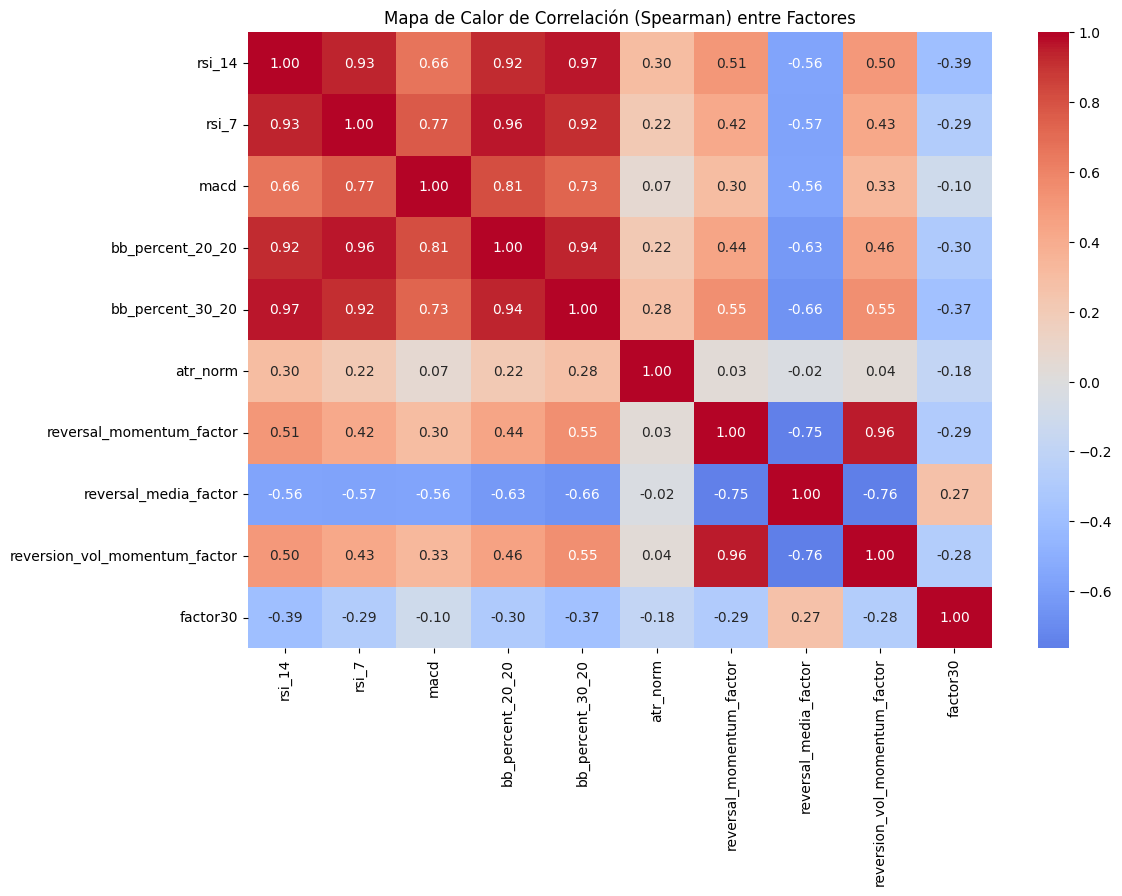

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista combinada de factores
factores = [
    'rsi_14', 'rsi_7', 'macd', 'bb_percent_20_20', 'bb_percent_30_20', 'atr_norm',
    'reversal_momentum_factor', 'reversal_media_factor',
    'reversion_vol_momentum_factor', 'factor30'
]

# Calcular la matriz de correlación de Spearman
corr_matrix = mnq_intraday[factores].corr(method='spearman')

# Mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Mapa de Calor de Correlación (Spearman) entre Factores')
plt.show()

In [47]:
# Calcular la matriz de correlación
corr_matrix = mnq_intraday[factores].corr(method='spearman')

# Convertir la matriz en una tabla larga (formato tidy)
corr_table = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_table = corr_table.stack().reset_index()
corr_table.columns = ['Factor 1', 'Factor 2', 'Correlación (Spearman)']

# Ordenar por valor absoluto de la correlación
corr_table['|Correlación|'] = corr_table['Correlación (Spearman)'].abs()
corr_table = corr_table.sort_values(by='|Correlación|', ascending=False).drop(columns='|Correlación|')

# Mostrar las primeras filas
print(corr_table.head(10))

                    Factor 1                       Factor 2  \
3                     rsi_14               bb_percent_30_20   
10                     rsi_7               bb_percent_20_20   
40  reversal_momentum_factor  reversion_vol_momentum_factor   
24          bb_percent_20_20               bb_percent_30_20   
0                     rsi_14                          rsi_7   
2                     rsi_14               bb_percent_20_20   
11                     rsi_7               bb_percent_30_20   
17                      macd               bb_percent_20_20   
9                      rsi_7                           macd   
42     reversal_media_factor  reversion_vol_momentum_factor   

    Correlación (Spearman)  
3                 0.965296  
10                0.961727  
40                0.957536  
24                0.943709  
0                 0.933124  
2                 0.921218  
11                0.916675  
17                0.810883  
9                 0.769787  
42              

# OTROS

In [ ]:
#def reset_dataset():
#  mnq_intraday = add_targets(load_df())
#  return mnq_intraday